# Analysis.

In [4]:
import pandas as pd
from pandas import json_normalize
import numpy as np

import requests 
import json
import os
from dotenv import load_dotenv #conda install -c conda-forge python-dotenv

import warnings
warnings.filterwarnings("ignore")

import time
import importlib
import src.extraction as ex
importlib.reload(ex)

<module 'src.extraction' from 'd:\\ironhack\\proyectos\\PipeLine_proy2\\src\\extraction.py'>

## 1. USDA food database.
### 1.1. Exploration.

Did a research of all the USDA csv files and select only the more relevant for this proyect, they have a lot of information about comples dishes, lab tests, market prices, etc. 
    1. Searching for the right tables with value information for the proyect. 
    2. Cleaning each table, droping the columns and probably some rows with no need it information, will try to merge it in python by changing the name of tha columns to the same in each. exported as csv 
    3. Merge the tables.

#### 1.1.1. "Food csv".
Data frame of food, it has its id number and name of food.

In [5]:
url = "D:\ironhack\proyectos\PipeLine_proy2\\USDA_main_csv\\food.csv"
food = ex.import_csv (url)
food.sample()

,fdc_id,data_type,description,food_category_id,publication_date
879192,1451491,branded_food,DARK CHOCOLATE VANILLA NUTS & FRUIT DIPPED CLU...,NaN,2021-02-26


In [6]:
food.shape

(1185090, 5)

##### 1.1.1.1. Deleting.
Will remove the "food_category_id", "data_type" and the "publication_date" column and try to remove the index column, it appears that it does not do much, it doest have a column name for identification

In [7]:
food = ex.delete_food (food)
food.sample()

,fdc_id,description
111900,399467,"SPARTAN, MINIS CORN DOGS, HONEY"


In [8]:
food.duplicated().sum()

0

#### 1.1.2. "Nutrients Table".
In this table can relate the data of nutrients and in wich food they are. they specifie the mount of the nutrient per 100g of food. Specified in unit defined in the nutrient table.

In [9]:
url2 = "D:\ironhack\proyectos\PipeLine_proy2\\USDA_main_csv\\nutrient.csv"
nutrient = ex.import_csv(url2)
nutrient.sample()

,id,name,unit_name,nutrient_nbr,rank
392,1396,(+) -Gallo catechin,MG,794.0,NaN


In [10]:
nutrient.shape

(463, 5)

##### 1.1.2.1. Deleting.
Will delete must of the columns, except name and id, but will create a copy so i dont lose the information, could help me in the future.

In [11]:
nutrient = ex.delete_nutrient (nutrient)
nutrient.sample()

,id,name
44,1045,Salicylic acid


#### 1.1.3. "Food_id Nutrient_id"
This table doesn´t appear in the information docs, but it loocks really helfull allready matching the nutrient with the food and the portion per 100g. Wont delete any column, but will start to change names of each Data Frame to matched them later. 

In [12]:
url3 = "D:\ironhack\proyectos\PipeLine_proy2\\USDA_main_csv\\JCS_FoodId-NutrientId-Per100g.csv"
ides = ex.import_csv (url3)
ides.sample()

,FoodId,NutrientId,Per100g
3352241,406017,1166,0.385


### 1.2. Merging.
Will merge all data frames into one, will chose the right tables for it and clean it more.

Looking for same elements in different tables at the ID rows, will change the names to matched them.

#### 1.2.1. Rename.

In [13]:
# change decription to food
# change fdc_id to food_id
food.rename(columns= {"fdc_id" : "food_id", "description" : "food"}, inplace=True)
food.sample()

,food_id,food
87936,375503,DICED TOMATOES & GREEN CHILIES ORIGINAL


In [14]:
#change NutrientId to nutrient_id
#change foodId to food_id
ides.rename(columns= {"FoodId" : "food_id", "NutrientId" : "nutrient_id", 'Per100g ' : "Per100g"}, inplace=True)
ides.sample()

,food_id,nutrient_id,Per100g
13726472,1597041,606,10.71


In [15]:
# change id to nutrient_id
# change name to nutrient
nutrient.rename(columns= {"name" : "nutrient", "id" : "nutrient_id"}, inplace=True)
nutrient.sample()

,nutrient_id,nutrient
420,2011,TFA 17:1 t


#### 1.2.2. Merge.
Will do a inner merge, now with the same column name. also cleaned some other columns by doing drop, the id columns.

In [16]:
usda = ex.merge (nutrient, ides, food)
usda.sample()

,food,nutrient,Per100g
3416240,CARAWAY CRISPY CRACKERS,iron,4.8


Make the elements in column nutrient more equal for a better filtration.

In [17]:
usda["nutrient"] = usda["nutrient"].apply(lambda x: x.lower())
usda["nutrient"] = usda["nutrient"].apply(lambda x: x.split(",")[0])

In [18]:
usda.sample(5)

,food,nutrient,Per100g
6437325,"IRISH CREAM COFFEE CREAMER, IRISH CREAM",protein,0.000
327998,"Milk, whole, 3.25% milkfat, with added vitamin D",vitamin a,162.000
5411695,"GREEN OLIVE, CHEESE & ROSEMARY BAKED CHEESE BITES",energy,533.000
271093,"Beef, rib, large end (ribs 6-9), separable lea...",glutamic acid,4.136
2479081,"SOUTHERN REFRESH MINTS, THE ORIGINAL COTTON CA...",vitamin a,0.000


In [19]:
usda.shape

(7555511, 3)

In [20]:
usda.duplicated().sum()

2397702

In [21]:
usda.drop_duplicates(keep='first')

,food,nutrient,Per100g
0,Hummus,nitrogen,1.28
1,Hummus,total lipid (fat),19.00
2,Hummus,ash,1.98
3,Hummus,water,56.30
4,Hummus,nitrogen,1.29
...,...,...,...
7555478,"OIL, OLIVE, EXTRA LIGHT",delta-7-stigmastenol,21.90
7555479,"OIL, PEANUT",stigmastadiene,0.00
7555487,"OIL, SUNFLOWER",stigmastadiene,0.00
7555495,"OIL, SAFFLOWER",stigmastadiene,0.00


In [22]:
usda.Per100g.value_counts()

0.000       2332591
3.570         55609
10.000        47297
25.000        39924
1.000         39784
             ...   
176.990           1
6.304             1
3588.000          1
4890.000          1
12.095            1
Name: Per100g, Length: 26968, dtype: int64

## 2. HEALTH CARE web scraping.
### 2.1. Exploration.
Got the information from the page vedantu, about some nutrients and what causes the lak of them.
#### 2.1.1. Get the link.

In [23]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re
import lxml
import importlib
import src.extraction as ex
importlib.reload(ex)

<module 'src.extraction' from 'd:\\ironhack\\proyectos\\PipeLine_proy2\\src\\extraction.py'>

In [24]:
url = "https://www.vedantu.com/biology/deficiency-diseases"
tags = ex.get_text(url)

#### 2.2. Searching for the info. 
Filter the elements wee need from the web page, we will need only the texts.

In [25]:
tag_1 = tags[37:55]
tag_2 = tags[60:68]
tag_3 = tags[73:91]

In [26]:
info_1 = ex.text_filtered(tag_1)
info_2 = ex.text_filtered(tag_2)
info_3 = ex.text_filtered(tag_3)

Creating the lists into a data frame, it made it into a single column frame, had to separate the information into 2 columns, nutrients and the information, and at the end put the 3 data frames into 1.

In [27]:
df = ex.db_concat (info_1, info_2, info_3)
df.reset_index(drop=True, inplace=True)
df

,nutrients,info
0,thiamine (vitamin b1),severe deficiency causes beriberi with symptom...
1,riboflavin (vitamin b2),the deficiency of this vitamin causes angular ...
2,niacin (vitamin b3),causes pellagra which is a life-threatening di...
3,pantothenic acid (vitamin b5),vitamin b5 deficiency is rare and the symptoms...
4,vitamin b6,end-stage kidney diseases such as celiac disea...
5,biotin (vitamin b7),the deficiency affects the growth of hair and ...
6,folate (vitamin b9),it is very common and the deficiency is associ...
7,vitamin b12,deficiency of this disease leads to pernicious...
8,ascorbic acid (vitamin c),deficiency results in scurvy and the symptoms ...
9,retinol (vitamin a),the deficiency causes night blindness or nycta...


Had to do the searching for the disease manually.

In [28]:
lsttotal = list(df["info"])
lsttotal[20]

'the deficiency of phosphorus leads to the formation of underdeveloped teeth and bones.'

In [29]:
lsttotal = list(df["info"])
lst0 = lsttotal[0]
lst1 = lsttotal[1]
lst2 = lsttotal[2]
lst3 = lsttotal[3]
lst4 = lsttotal[4]
lst5 = lsttotal[5]
lst6 = lsttotal[6]
lst7 = lsttotal[7]
lst8 = lsttotal[8]
lst9 = lsttotal[9]
lst10 = lsttotal[10]
lst11 = lsttotal[11]
lst12 = lsttotal[12]
lst13 = lsttotal[13]
lst14 = lsttotal[14]
lst15 = lsttotal[15]
lst16 = lsttotal[16]
lst17 = lsttotal[17]
lst18 = lsttotal[18]
lst19 = lsttotal[19]
lst20 = lsttotal[20]
lst21 = lsttotal[21]


In [30]:
dis0 = ex.diseases (lst0)
dis1 = ex.diseases (lst1)
dis2 = ex.diseases (lst2)
dis3 = ex.diseases (lst3)
dis4 = ex.diseases (lst4)
dis5 = ex.diseases (lst5)
dis6 = ex.diseases (lst6)
dis7 = ex.diseases (lst7)
dis8 = ex.diseases (lst8)
dis9 = ex.diseases (lst9)
dis10 = ex.diseases (lst10)
dis11 = ex.diseases (lst11)
dis12 = ex.diseases (lst12)
dis13 = ex.diseases (lst13)
dis14 = ex.diseases (lst14)
dis15 = ex.diseases (lst15)
dis16 = ex.diseases (lst16)
dis17 = ex.diseases (lst17)
dis18 = ex.diseases (lst18)
dis19 = ex.diseases (lst19)
dis20 = ex.diseases (lst20)
dis21 = ex.diseases (lst21)

In [31]:
lista = ex.diseases_total (dis0, dis1, dis2, dis3, dis4, dis5, dis6, dis7, dis8, dis9, dis10, dis11, dis12, dis13, dis14, dis15, dis16, dis17, dis18, dis19, dis20, dis21) 

Making them a data frame.

In [32]:
enf = ex.df_diseases (lista)
enf.columns=["diseases"]
enf

,diseases
0,beriberi/ weight loss/ weakness
1,anaemia/ angular cheilitis/ chapped/ cracked lips
2,pellagra/ diarrhoea/ dermatitis/ dementia
3,fatigue/ apathy/ irritability
4,anaemia/ dermatitis/ celiac disease/ crohn/ ki...
5,skin health
6,neural tube defects
7,anaemia/ methylmalonic acidemia
8,scurvy/ skin spots
9,nyctalopia/ keratomalacia/ blindness


2.3. Making the Data frame.

In [33]:
x = pd.concat([df, enf], axis=1)
x.sample()

,nutrients,info,diseases
16,potassium deficiency,the common cause of potassium deficiency is ex...,vomiting/ kidney disease


In [34]:
disess = x.reindex(columns = ['nutrients','diseases','info'])
disess.sample()

,nutrients,diseases,info
19,sodium,hyponatremia/ dehydration/ heart diseases,sodium deficiency is also known as hyponatremi...


## 3. Mixing information.
### 3.1. from the 2 Data Frames.
From the information I gather doing web scraping I will put themm toghether into one, will filtrate the information from the usda table to choose only the diseases I got from the web scraping, that will throw the info I want for this proyect.

In [35]:
usda = (usda.loc[(usda['nutrient'] == "thiamine") | (usda['nutrient'] == "riboflavin") | (usda['nutrient'] == "niacin") | (usda['nutrient'] == "pantothenic") | (usda['nutrient'] == "vitamin b6") | (usda['nutrient'] == "biotin") | (usda['nutrient'] == "folate") | (usda['nutrient'] == "vitamin b12") | (usda['nutrient'] == "ascorbic acid") | (usda['nutrient'] == "retinol") | (usda['nutrient'] == "calciferol") | (usda['nutrient'] == "phylloquinone") | (usda['nutrient'] == "tocopherol") | (usda['nutrient'] == "calcium") | (usda['nutrient'] == "iron") | (usda['nutrient'] == "magnesium") | (usda['nutrient'] == "potassium") | (usda['nutrient'] == "zinc") | (usda['nutrient'] == "iodine") | (usda['nutrient'] == "sodium") | (usda['nutrient'] == "phosphorus") | (usda['nutrient'] == "manganese")])

In [36]:
usda.drop_duplicates(subset=['food', 'nutrient'], keep='first', inplace= True)

In [37]:
usda 

,food,nutrient,Per100g
183,"Hummus, commercial",calcium,41.00
184,"Hummus, commercial",iron,2.41
185,"Hummus, commercial",magnesium,71.10
186,"Hummus, commercial",phosphorus,166.00
187,"Hummus, commercial",potassium,289.00
...,...,...,...
7513038,"MUSHROOMS, LIONS MANE",folate,33.80
7513046,"SPINACH, REGULAR (MATURE)",folate,120.00
7513054,"SPINACH, BABY",folate,90.40
7513062,"TOMATOES, ROMA",folate,11.10


Create new columns with the amounts of nutrients, "nutri_counts" for how many diversity of nutrients does it have, and "sum" for the total amount of grams per 100g that from each nutrient that each food has.

In [47]:
usdaa = ex.groupby (usda)

### 3.2. Final Data Frame.
Filter from the columns "nutri_counts" and "sum" to make way shorter the table and get to the most powerfull food.
This function I can use to get the information for the graphs.

2 different types of super foods that will analys.

    - food with the most cuantity by number of nutrients.
    - food with the more grams of nutrients per 100g.

In [93]:
nutri12 = ex.for_graphs_lastfilter (usdaa, 14.00, 100)
nutri12.sample()

,food,nutrient,Per100g,nutri_counts,sum
7470796,"Butter, stick, salted",phosphorus,22.0,15,1340.735


We can see that theres some false information because of the cuantity of grams per nutrient in some foods, it looks false.
will probably try to eliminated ----- for lack of time I wont do it :P

In [95]:
grams = ex.for_graphs_lastfilter (usdaa, 0.00, 2500000)
grams.sample(10)

,food,nutrient,Per100g,nutri_counts,sum
5613759,"SIMPLE TRUE ORGANIC, CEREAL TOASTED OATS",folate,166666667.0,7,1.666680e+08
4008814,NABISCO OREO COOKIE CRUMBS CRUMBS 1X25.000 LB,manganese,0.0,5,3.448560e+06
6082302,"INSTANT ICED TEA MIX, LEMON",calcium,14.0,5,3.928572e+08
4025650,OREO COOKIES 1X20.000 LB,folate,3448276.0,5,3.448562e+06
4008811,NABISCO OREO COOKIE CRUMBS CRUMBS 1X25.000 LB,zinc,0.0,5,3.448560e+06
5781448,ANCHOVIES IN OLIVE OIL,sodium,4687500.0,3,4.687752e+06
5682941,DRY AGED BEEF PANKO BREADCRUMBS,sodium,3500000.0,1,3.500000e+06
6614023,"CALYPSO RUB, SWEET & SPICY CARIBBEAN SPICE BLEND.",iron,0.0,3,1.095238e+07
6131298,"RAW ITALIAN ALMOND BUTTER, RAW ITALIAN ALMOND",calcium,286.0,4,7.500000e+09
5590960,WICKED SPICE,sodium,5800000.0,1,5.800000e+06


In [75]:
len(nutri12)

90

In [88]:
len(grams)

76

## 4. Graphics.
With all the information that we gather from the dataframes, after filter and cleaning them, will pass to do some visualizations to get a clearer idea and to prouf iour hypothesis.

Will change the values in this formula depending od which output we want to have.

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

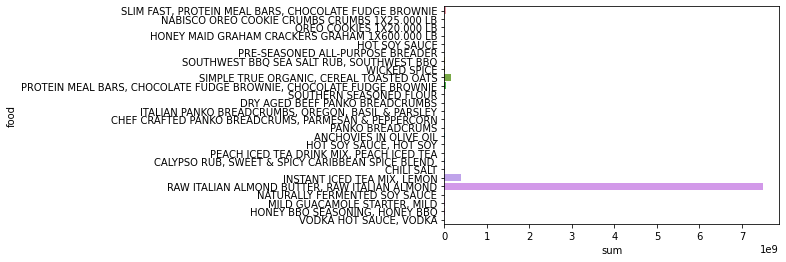

In [91]:
grms = sns.barplot(y="food", x="sum", data=grams);

In [ ]:
we can see the foods with the most cuantity of nutrients, more than 14 diferent types of nutrients, and how many grams in total they have. 
it looks that the butter has the most of them. 

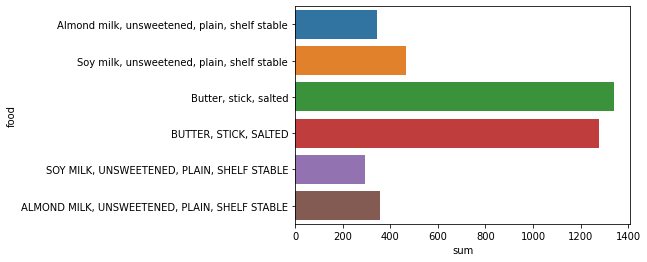

In [92]:
more_than_14 = sns.barplot(y="food", x="sum", data=nutri12);

a list of food with no more than 12 different types of nutrients and more than 10,000 amount of grams, this is a more equilibrated graphs and still powerfull foods.

In [99]:
nutri12 = ex.for_graphs_lastfilter (usdaa, 12.00, 10000)
len(nutri12)

91

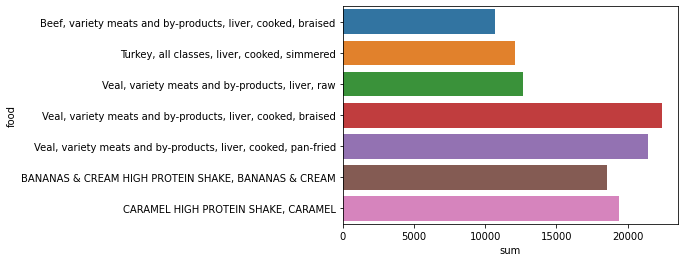

In [100]:
more_than_14 = sns.barplot(y="food", x="sum", data=nutri12);

Can see that the cooked liver food with bread is powerful. and has more than 20,000 grams, but we can see that also the bananas shake or high protein shake its also has good amount of nutrients. 